![Fraud Detection](shutterstock_1874193907.jpg)

# Bank Fraud Detection with Imbalanced Data: Applying Oversampling and Hyperparameter Optimization

In this project of bank fraud detection, was used data generated by the Paysim simulator, made available on the [Kaggle platform](https://www.kaggle.com/datasets/ealaxi/paysim1). The selection of this dataset was based on its ability to accurately represent real-world financial transaction scenarios. The Paysim simulator is widely used as a benchmark tool to test the effectiveness of fraud detection models, ensuring the validity and relevance of the obtained results.

***

## Details of the Dataset Columns

| Column Name      | Description                                                                                     |
|:------------------:|:-------------------------------------------------------------------------------------------------:|
| step             | Unit of time in the real world (1 hour)                                                         |
| type             | CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER                                                  |
| amount           | Amount of the transaction in local currency                                                     |
| nameOrig         | Customer who started the transaction                                                            |
| oldbalanceOrg    | Initial balance before the transaction                                                          |
| newbalanceOrig   | New balance after the transaction                                                               |
| nameDest         | Recipient of the transaction                                                                    |
| oldbalanceDest   | Initial recipient balance before the transaction                                                |
| newbalanceDest   | New recipient balance after the transaction                                                     |
| isFraud          | Fraud agent takes control of customers accounts and attempts to empty it by transferring to another account and then cashing out |
| isFlaggedFraud   | An illegal attempt to transfer more money than is available in one transaction                  |


***

## Importing Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import os

from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score,recall_score,precision_score, roc_curve
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterSampler, cross_validate, RandomizedSearchCV, KFold
from datetime import datetime
os.environ['GIT_PYTHON_REFRESH'] = 'quiet'

***
## Loading and Initial Exploration of the Dataset

This step involves reading the dataset using pandas, followed by an initial evaluation of the data. </br>First, the dataset's format is checked using the shape function, then information about the columns and data types is obtained using the info() function. Next, the presence of null values is checked using the isnull() and sum() functions.


In [2]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
#df = pd.read_csv("fraud_dataset_example.csv")
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [3]:
print('Dataset Shape:\n{} rows\n{} columns'.format(df.shape[0],df.shape[1]))

Dataset Shape:
6362620 rows
11 columns


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

***

## Exploratory Data Analysis
### Overview of Dataset Statistics

In [6]:
df.describe().T.apply(lambda s: s.apply('{0:.5f}'.format))

,count,mean,std,min,25%,50%,75%,max
step,6362620.00000,243.39725,142.33197,1.00000,156.00000,239.00000,335.00000,743.00000
amount,6362620.00000,179861.90355,603858.23146,0.00000,13389.57000,74871.94000,208721.47750,92445516.64000
oldbalanceOrg,6362620.00000,833883.10407,2888242.67301,0.00000,0.00000,14208.00000,107315.17500,59585040.37000
newbalanceOrig,6362620.00000,855113.66858,2924048.50297,0.00000,0.00000,0.00000,144258.41000,49585040.37000
oldbalanceDest,6362620.00000,1100701.66652,3399180.11297,0.00000,0.00000,132705.66500,943036.70750,356015889.35000
newbalanceDest,6362620.00000,1224996.39820,3674128.94209,0.00000,0.00000,214661.44000,1111909.25000,356179278.92000
isFraud,6362620.00000,0.00129,0.03590,0.00000,0.00000,0.00000,0.00000,1.00000
isFlaggedFraud,6362620.00000,0.00000,0.00159,0.00000,0.00000,0.00000,0.00000,1.00000


### Percentage of Occurrences by Type of Bank Operation

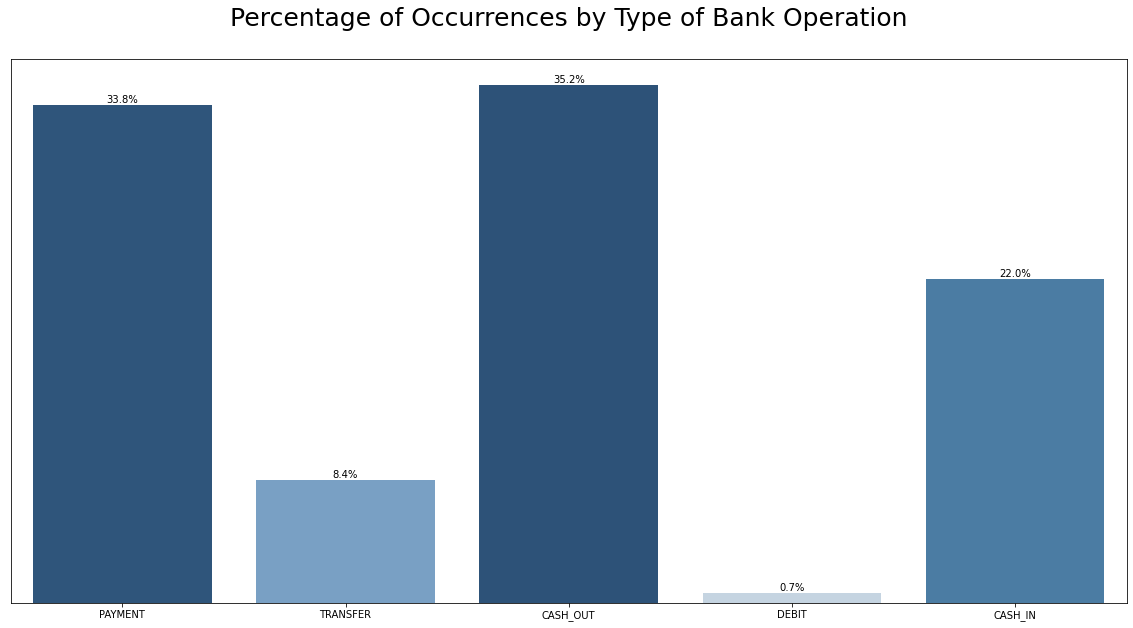

In [7]:
plt.figure(figsize = (20,10))
plt.title('Percentage of Occurrences by Type of Bank Operation',fontsize=25, y=1.05)
colors = ["#225588", "#6DA0D0", "#215284", "#C0D4E6", "#3D7DB1"]
ax = sns.countplot(x=df.type, palette = colors)

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height()/len(df.type)), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
ax.set(yticklabels=[])

#ax.spines['left'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.set_xlabel('');
ax.set_ylabel('');
ax.yaxis.set_ticks([])
plt.show()

This bar chart presents the percentage of occurrences by type of banking operation in the dataset. It can be observed that the "Cash_out" operation is the most frequent, accounting for 35.2% of all transactions. Following this, the "Payment" operation represents 33.8% of the transactions. "Cash_in" operations make up 22% of the transactions, while "Transfer" operations constitute 8.4%. The "Debit" operations are the least frequent, constituting just 0.7% of all transactions.

### Percentage of Occurrences of Frauds by Type of Bank Operation

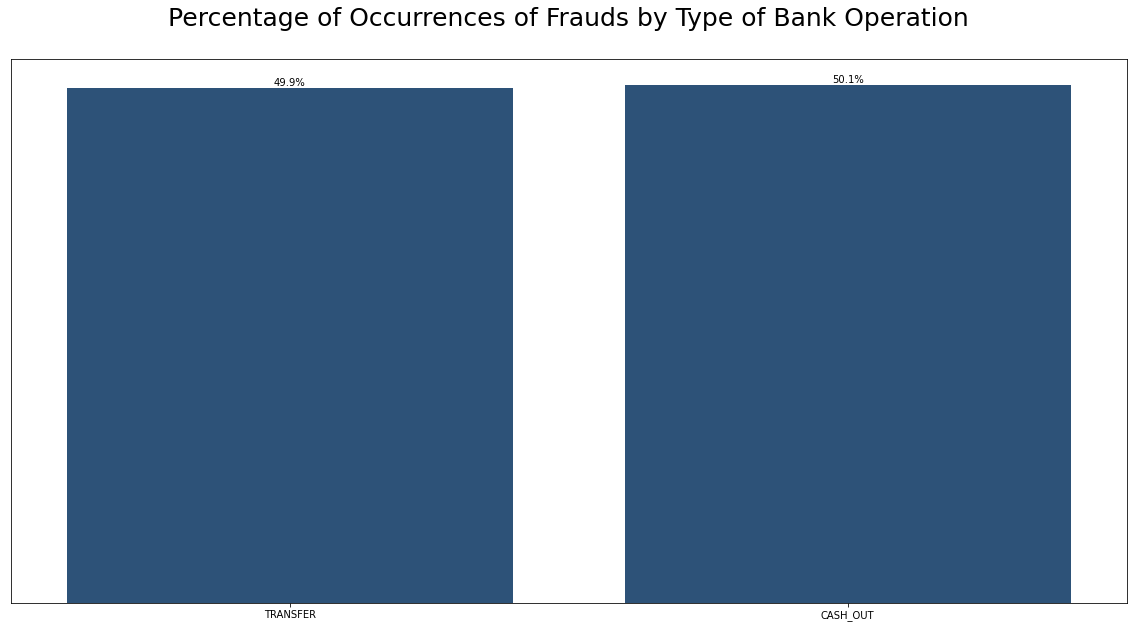

In [8]:
frauds = df[df['isFraud'] == 1]
plt.figure(figsize = (20,10))
plt.title('Percentage of Occurrences of Frauds by Type of Bank Operation',fontsize=25, y=1.05)
colors = ["#215284", "#215284"]
ax = sns.countplot(x=frauds.type, palette = colors)

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height()/len(frauds.type)), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
#ax.axis('off')
ax.set(yticklabels=[])
#ax.spines['left'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.set_xlabel('');
ax.set_ylabel('');
ax.yaxis.set_ticks([])

plt.show()

This chart displays the distribution of fraud occurrences by type of banking operation in the dataset. Remarkably, the "Transfer" and "Cash_out" operations encompass all fraudulent transactions, with "Transfer" accounting for 49.9% and "Cash_out" constituting 50.1%. It is notable that the "Payment", "Debit", and "Cash_in" operations do not have any recorded fraud occurrences, suggesting that fraudulent activity in this dataset is concentrated in the "Transfer" and "Cash_out" operations.

### Fraud Occurrences among All Transactions

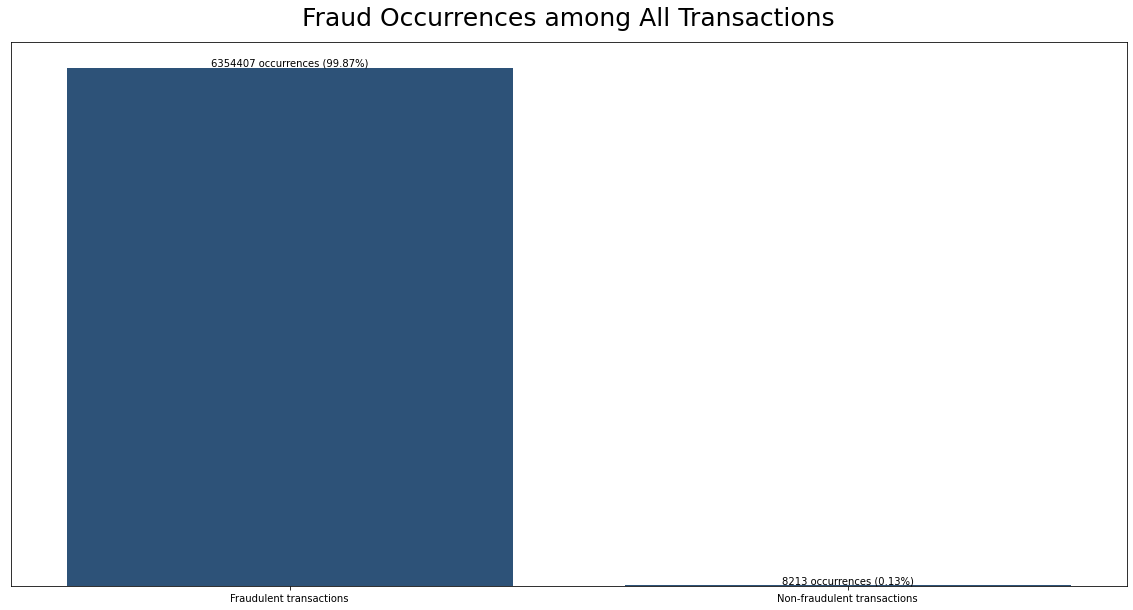

In [9]:
frauds = df[df['isFraud'] == 1]
plt.figure(figsize = (20,10))
plt.title('Fraud Occurrences among All Transactions',fontsize=25, y=1.02)
colors = ["#215284"]
ax = sns.countplot(x=df.isFraud, palette = colors)

for p in ax.patches:
    ax.annotate('{} occurrences ({:.2f}%)'.format(p.get_height(),100 * p.get_height()/df.shape[0]), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    #print(p.get_height())
    
#ax.axis('off')
ax.set(yticklabels=[])
#ax.spines['left'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.set_xlabel('');
ax.set_ylabel('');
ax.xaxis.set_ticklabels(['Non-fraudulent transactions', 'Fraudulent transactions'])
ax.yaxis.set_ticks([])
plt.show()

This chart illustrates the distribution of fraudulent and non-fraudulent transactions within the entire dataset. Non-fraudulent transactions overwhelmingly dominate the data, comprising 6,354,407 instances or 99.87% of all transactions. Meanwhile, fraudulent transactions are considerably rarer, accounting for just 8,213 instances or 0.13% of the total.

While at first glance this may seem reassuring, it underscores a critical challenge in utilizing this dataset for machine learning models. The substantial class imbalance between fraudulent and non-fraudulent transactions necessitates careful preprocessing and selection of appropriate modelling techniques to ensure that the rare but significant class of fraudulent transactions is accurately detected and predicted.

### Fraud Occurrences by Day

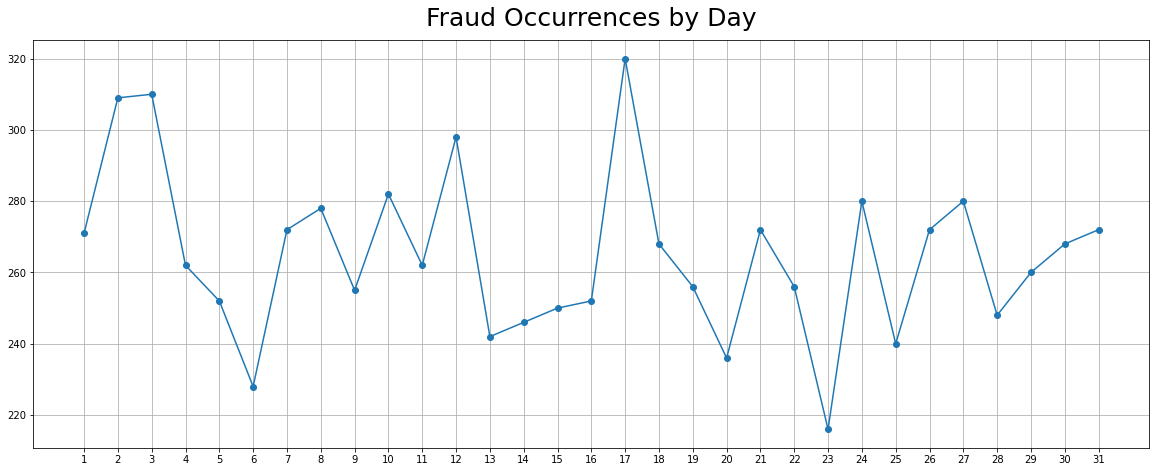

In [10]:
plt.figure(figsize = (20,7.5))
df2 = df.copy()
df2['day'] = (df2['step'] + 23) // 24
fpd = df2.groupby('day').sum()['isFraud']
plt.title('Fraud Occurrences by Day',fontsize=25, y=1.02)
plt.plot(fpd.index, fpd.values, marker='o', linestyle='-')
plt.axhline(y=fpd.values.mean(), color='r', linestyle='--')
plt.xticks(range(1,32));
plt.grid(True)

This chart presents the number of frauds occurring each day over a period of a month. The quantity of frauds varies from day to day, but does not show an evident pattern or clear trend. The daily number of frauds fluctuates between 216 and 320 occurrences.

The day with the highest number of recorded frauds is the 17th, with a total of 320 occurrences, while the day with the fewest frauds is the 23rd, with 216 occurrences.

The red dashed line in the chart represents the average daily fraud occurrences, calculated over the whole month. This line provides a reference point against which to compare the number of frauds on any given day, making it easier to identify days with unusually high or low numbers of frauds.

### Fraud Occurrences by hour

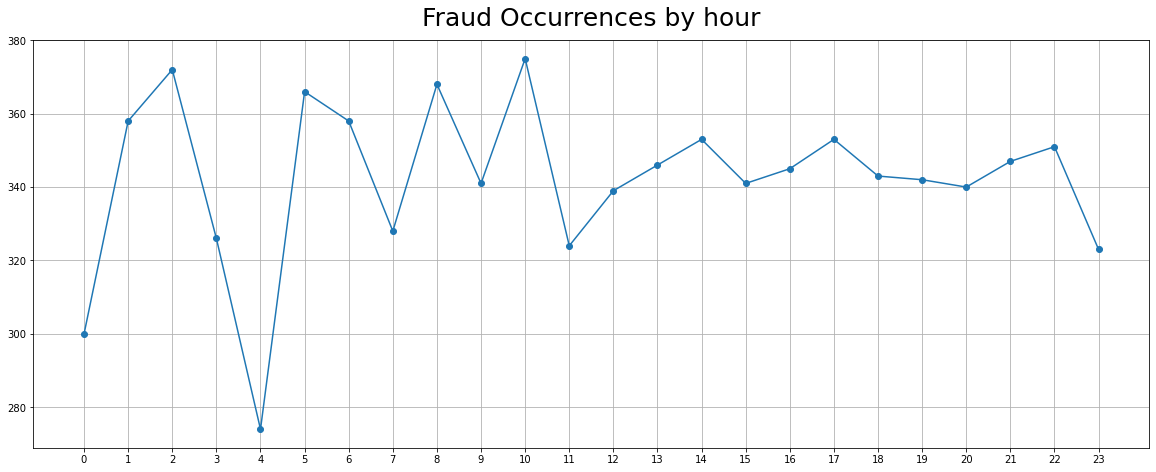

In [11]:
plt.figure(figsize = (20,7.5))
df2['hour'] = df2['step'] % 24
fph = df2.groupby('hour').sum()['isFraud']
plt.title('Fraud Occurrences by hour',fontsize=25, y=1.02)
plt.plot(fph.index, fph.values, marker='o', linestyle='-')
plt.axhline(y=fph.values.mean(), color='r', linestyle='--')
plt.xticks(range(0,24));
plt.grid(True)

This chart presents the number of frauds occurring each hour throughout a day. The amount of frauds varies from hour to hour, yet does not present an obvious pattern or clear trend. The number of frauds per hour fluctuates between 274 and 375 occurrences.

The hour with the highest number of recorded frauds is 10 a.m., with a total of 375 occurrences, while the lowest number of frauds is recorded at 4 a.m., with 274 occurrences.

Significantly, a red horizontal line intersects the chart, representing the average number of fraud occurrences per hour. This line serves as a benchmark, allowing us to better comprehend the variations in the data, above or below the mean.

### Fraud Distribution by Day

,mean,std,min,25%,50%,75%,max
isFraud,11.053836,4.998631,0.0,8.0,10.0,14.0,40.0


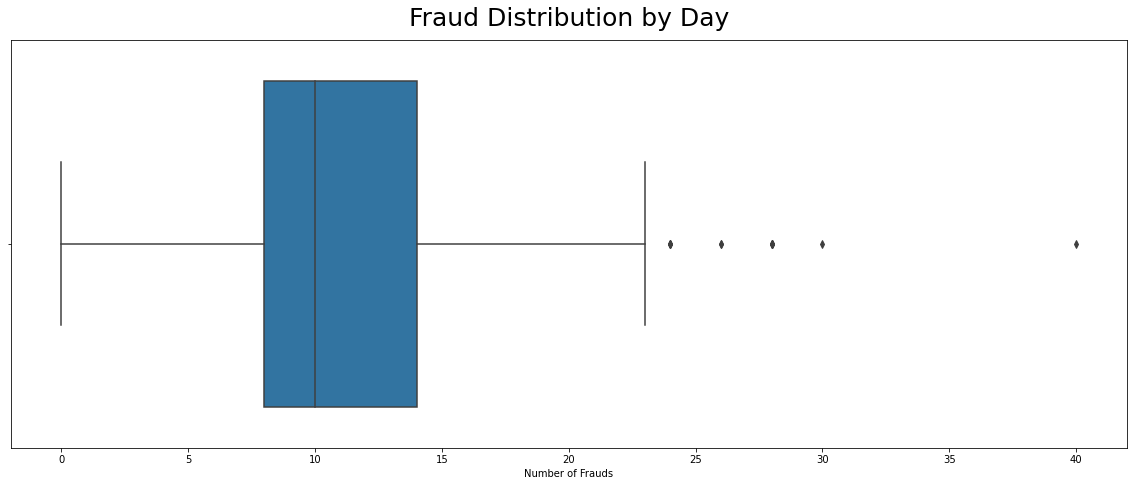

In [12]:
plt.figure(figsize = (20,7.5))
plt.title('Fraud Distribution by Day',fontsize=25, y=1.02)
fps = df2.groupby('step').sum()['isFraud']
sns.boxplot(x=fps);
plt.xlabel('')
plt.xlabel('Number of Frauds');

f = pd.DataFrame(fps.describe()).T
f.iloc[:,1:]

#plt.grid(True)

This chart is a boxplot that represents the distribution of frauds per day. The central box of the chart represents the interquartile range (IQR), meaning, 50% of the data lies within this box. The line inside the box indicates the median of the data.

The "tails" extending out from the box show the variability outside the IQR, while the dots represent possible outliers or anomalies in the data.

### Descriptive Statistics by Type

In [13]:
gb = df2[['type','amount']].groupby('type')
gb.describe()

amount                                                  \
              count           mean           std   min          25%   
type                                                                  
CASH_IN   1399284.0  168920.242004  1.265083e+05  0.04   70510.1825   
CASH_OUT  2237500.0  176273.964346  1.753297e+05  0.00   72669.6500   
DEBIT       41432.0    5483.665314  1.331854e+04  0.55    1500.1800   
PAYMENT   2151495.0   13057.604660  1.255645e+04  0.02    4383.8200   
TRANSFER   532909.0  910647.009645  1.879574e+06  2.60  215905.3500   

                                                
                 50%          75%          max  
type                                            
CASH_IN   143427.710  239899.0875   1915267.90  
CASH_OUT  147072.185  246539.4775  10000000.00  
DEBIT       3048.990    5479.1750    569077.51  
PAYMENT     9482.190   17561.2200    238637.98  
TRANSFER  486308.390  974958.0000  92445516.64

This table provides detailed descriptive statistics for different types of banking operations: "CASH_IN", "CASH_OUT", "DEBIT", "PAYMENT", and "TRANSFER".

Each type of operation is analyzed in terms of the total transaction value, the mean value, the standard deviation (indicating the dispersion of the values), as well as the minimum and maximum values. Additionally, the quartiles (25%, 50%, and 75%) are presented, providing a view of the distribution of transaction values.

For instance, it can be observed that "TRANSFER" operations have the highest mean transaction value, indicating that this type of operation generally involves large amounts of money. On the other hand, "DEBIT" operations have the lowest mean value, suggesting that these operations involve small amounts of money.

Furthermore, the presence of high values for the standard deviation and the difference between the minimum and maximum in some banking operations, such as "CASH_OUT" and "TRANSFER", suggest a large variability in the amount of transactions for these types of operations.

### Checking occurrences of 'Flagged Frauds

In [14]:
df.groupby('isFlaggedFraud').count()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
isFlaggedFraud,,,,,,,,,,
0,6362604,6362604,6362604,6362604,6362604,6362604,6362604,6362604,6362604,6362604
1,16,16,16,16,16,16,16,16,16,16


In [15]:
q = df.query('isFlaggedFraud == 1')
q

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


The 'isFlaggedFraud' column in the dataset signifies an illegal attempt to transfer more money than is available in one transaction. After analyzing the data, it's observed that there are only 16 instances out of more than 6 million transactions where 'isFlaggedFraud' is marked as '1', indicating a potentially fraudulent transaction. This means that the 'isFlaggedFraud' column is heavily skewed towards '0'.

Given this significant class imbalance and the rarity of flagged fraudulent transactions, it was decided not to use the 'isFlaggedFraud' column in the classification algorithms. The low frequency of this flag makes it difficult to extract meaningful or generalizable patterns for modeling and prediction. Additionally, including this feature in the model may lead to overfitting, where the model performs well on the training data but poorly on unseen data.

In [16]:
df.drop('isFlaggedFraud', axis=1, inplace=True)

### Pearson Correlation Analysis

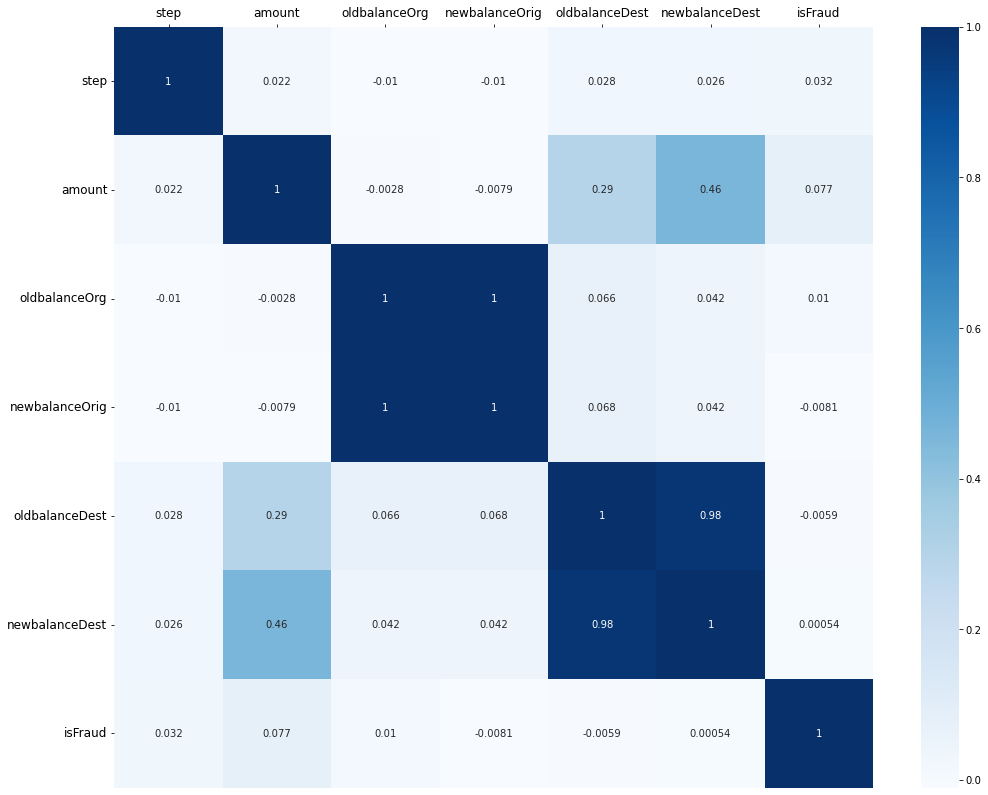

In [17]:
fig, ax = plt.subplots(figsize = (17,14))

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
g = sns.heatmap(df.corr(), annot=True, cmap="Blues", cbar=True);
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12);
g.set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 12);

This heatmap shows the Pearson correlation coefficients between different features in the dataset. The Pearson correlation coefficient measures the linear relationship between two datasets and ranges from -1 to 1, where a value of 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation.

***

## Data Encoding for ML Model Training

In [18]:
df_encoded = pd.get_dummies(data=df, columns=['type'])
df_encoded.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
df_encoded.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


In this step, data encoding was performed to prepare it for training the machine learning model. The pd.get_dummies() method was used to encode the 'type' column, which represents the transaction type. This resulted in the creation of binary variables for each transaction type, allowing the model to capture categorical information appropriately.

Next, the 'nameOrig' and 'nameDest' columns were removed, as they are not relevant to the model training. These columns contain user identification information associated with the transactions and do not directly contribute to fraud detection.

The result was a new dataframe called df_encoded, where the columns were encoded and the irrelevant columns were removed. The data is now ready to be used in training the fraud detection model. The provided code snippet shows the first few rows of the encoded dataframe.

This step is crucial for properly preparing the data, ensuring that the model can understand and interpret the transaction information accurately, thereby enhancing the effectiveness of fraud detection.

***

## Data Split: Dividing into Training and Test Sets

In [19]:
x = df_encoded.drop('isFraud',  axis=1)
y = df_encoded['isFraud']
x.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [20]:
SEED = 101

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = SEED)

In this step, the data was split into training and test sets using the train_test_split function. A seed value of 101 was used to ensure reproducibility of the experiments. This approach is useful for maintaining consistency in results and facilitating comparison across different models and configurations.

The data was divided such that 70% of the samples were assigned to the training set (x_train and y_train), while 30% were set aside for the test set (x_test and y_test). This division allows for evaluating the model's performance on unseen data and assessing its ability to generalize.

***

## Model Evaluation Functions: Metrics and Confusion Matrix

In [21]:
def conf_matrix(y_test, y_pred, plot = True):
    
    cmlst = []
    
    cm = confusion_matrix(y_test, y_pred)
    cmlst.append(cm)
    
    cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
    cmlst.append(cm_norm)
    
    if (plot==True):
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(20,10)
        
        cbar_ax = fig.add_axes([.91, .15, .03, .7])
        hm = sns.heatmap(cm, annot=True, annot_kws={"size": 18},fmt='.12g', ax=ax[0], cmap="Blues", square=True, cbar=True,cbar_ax=cbar_ax); 
        
        ax[0].set_xlabel('Predicted label', fontsize=18);
        ax[0].set_ylabel('True label', fontsize=18); 
        ax[0].set_title('Confusion Matrix', fontsize=18); 
        ax[0].xaxis.set_ticklabels(['0', '1']); 
        ax[0].yaxis.set_ticklabels(['0', '1']);  
        
        hm2 = sns.heatmap(cm_norm, annot=True, annot_kws={"size": 18} , fmt='.2%', ax=ax[1], cmap="Blues", square=True, cbar_ax = cbar_ax); 
        
        ax[1].set_xlabel('Predicted label', fontsize=18);
        ax[1].set_ylabel('True label', fontsize=18); 
        ax[1].set_title('Normalized confusion matrix with percentage values', fontsize=18); 
        ax[1].xaxis.set_ticklabels(['0', '1']); 
        ax[1].yaxis.set_ticklabels(['0', '1']);  
    return cmlst

A confusion matrix is a tabular representation that summarizes the performance of a classification model by showing the counts of true positive, true negative, false positive, and false negative predictions. It provides valuable insights into the model's ability to correctly classify instances, identify any imbalances between classes, and evaluate the trade-offs between different types of errors, such as false positives and false negatives. By analyzing the confusion matrix, we can gain a comprehensive understanding of the model's predictive accuracy and make informed decisions based on its performance.

![Metrics](metrics.png)

In [22]:
def model_metrics(model):
    
    y_pred = model.predict(x_test)
    
    lstMetrics = []
    lstMetrics.append(metrics.accuracy_score(y_test, y_pred))
    lstMetrics.append(metrics.precision_score(y_test, y_pred))
    lstMetrics.append(metrics.recall_score(y_test, y_pred))
    lstMetrics.append(metrics.f1_score(y_test, y_pred))
    
    df_metrics = pd.DataFrame(lstMetrics)
    df_metrics = df_metrics.T
    df_metrics = df_metrics.rename(columns={0: 'Accuracy Score', 
                                            1: 'Precision Score',
                                            2: 'Recall Score',
                                            3: 'F1 Score'})
    print(df_metrics.to_string(index=False) + '\n')
    
    conf_matrix(y_test, y_pred)

### Metrics:

<b>Accuracy Score</b>: The accuracy score measures the overall correctness of the model's predictions, calculating the ratio of correctly classified instances to the total number of instances. While accuracy is an important metric, in the case of imbalanced datasets, <b>it can be misleading due to the majority class overwhelming the minority class</b>.

<b>Precision Score</b>: Precision quantifies the ability of the model to correctly identify positive instances (fraudulent transactions) among the instances it predicted as positive. It calculates the ratio of true positive predictions to the total number of predicted positive instances. In the context of fraud detection, precision is <b>valuable in reducing false positives</b>, as it represents the proportion of correctly predicted fraud cases among all predicted fraud cases.

<b>Recall Score</b>: Recall, also known as sensitivity or true positive rate, measures the ability of the model to correctly identify positive instances among all actual positive instances. It calculates the ratio of true positive predictions to the total number of actual positive instances. In fraud detection, recall is crucial as it captures the ability to detect <b>true fraudulent transactions, minimizing false negatives</b>.

<b>F1 Score</b>: The F1 score is a harmonic mean of precision and recall, providing a single metric that balances both measures. It considers both the ability to reduce false positives and false negatives, making it useful for evaluating model performance in imbalanced datasets. The F1 score provides a balanced evaluation, taking into account the trade-off between precision and recall.

***

## Initial Model Evaluation with Imbalanced Data

Trained. Elapsed time: 28.08

Logistic regression metrics:
 Accuracy Score  Precision Score  Recall Score  F1 Score
       0.998354         0.368325      0.419528  0.392263



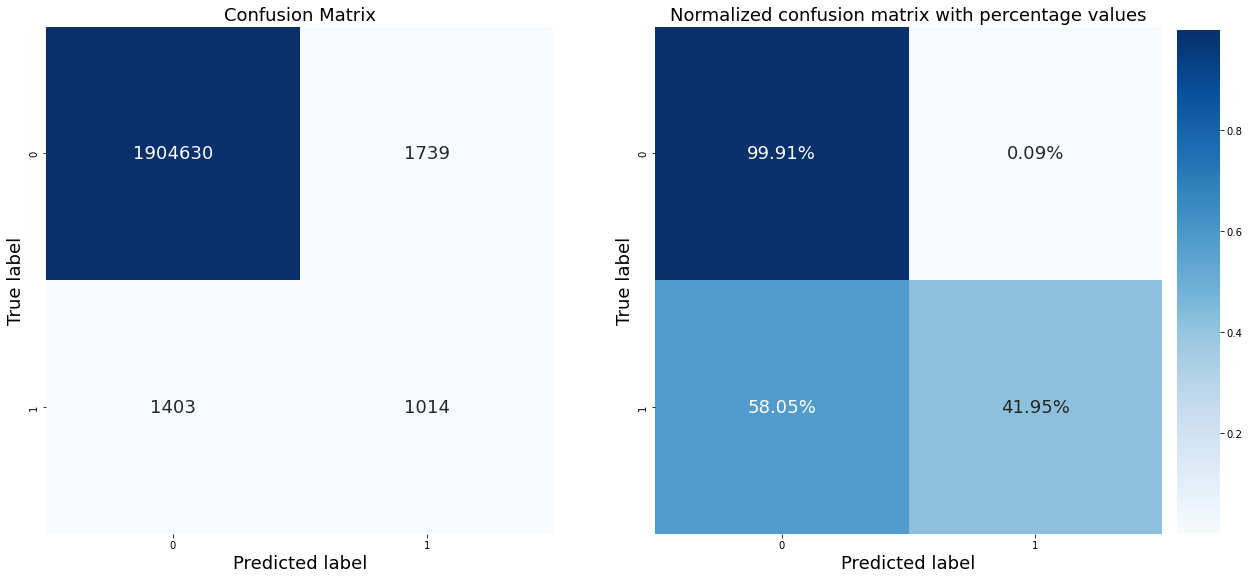

In [44]:
lr = LogisticRegression(max_iter=1000, random_state=SEED)
t1 = datetime.now()
lr.fit(x_train, y_train)
t2 = datetime.now()
fit_time = (t2-t1).total_seconds()
print('Trained. Elapsed time: {:.2f}\n'.format(fit_time))
print('Logistic regression metrics:')
model_metrics(lr)

In this stage, a logistic regression model was trained to perform the initial test using imbalanced data in order to observe the model's behavior. Subsequently, the "model_metrics" function was used to calculate the performance metrics of the model, which are presented as follows: an Accuracy Score of 0.998354, Precision Score of 0.368325, Recall Score of 0.419528, and F1 Score of 0.392263.
non-fraudulent transactions

Furthermore, a confusion matrix was generated to visualize the rates of correct and incorrect classification. The confusion matrix reveals that 99.91% of instances from the negative class (0) that are non-fraudulent transactions were correctly classified, while only 0.09% were non-fraudulent transactions incorrectly classified as fraud (1). On the other hand, in the positive class, it was observed that 41.95% of fraudulent transactions were correctly classified, while 58.05% were fraudulent transactions incorrectly classified as non-fraudulent.

It is important to note that, in cases like this, accuracy should not be considered in isolation as the sole metric to evaluate model performance. Due to the data imbalance, it is necessary to consider other metrics such as precision and recall, which take into account the false positive rate and the positive detection rate, respectively.

***

## Addressing Class Imbalance: Solving the Imbalance Problem
When it comes to classifying data, we sometimes run into a problem where our dataset is imbalanced. This means we have many more instances of one class than another. For example, in a dataset of credit card transactions, the vast majority of transactions are legitimate, but a small fraction are fraudulent. This imbalance can lead to difficulties in modeling, as the model will be biased towards predicting the majority class, resulting in poor performance in detecting the minority class (the fraudulent transactions).

### Cost-Sensitive Learning

Cost-Sensitive Learning is a technique used to handle such imbalanced datasets. It works by assigning a higher cost to misclassifying the minority class.
In a non-cost-sensitive learning approach, every error made by the model during the learning process is considered equal. However, cost-sensitive learning differentiates these errors, assigning them different weights or costs. This ensures the model learns to pay more attention to the minority class despite its smaller representation in the dataset.

Logistic regression metrics:
 Accuracy Score  Precision Score  Recall Score  F1 Score
       0.911551         0.012623      0.891601  0.024893



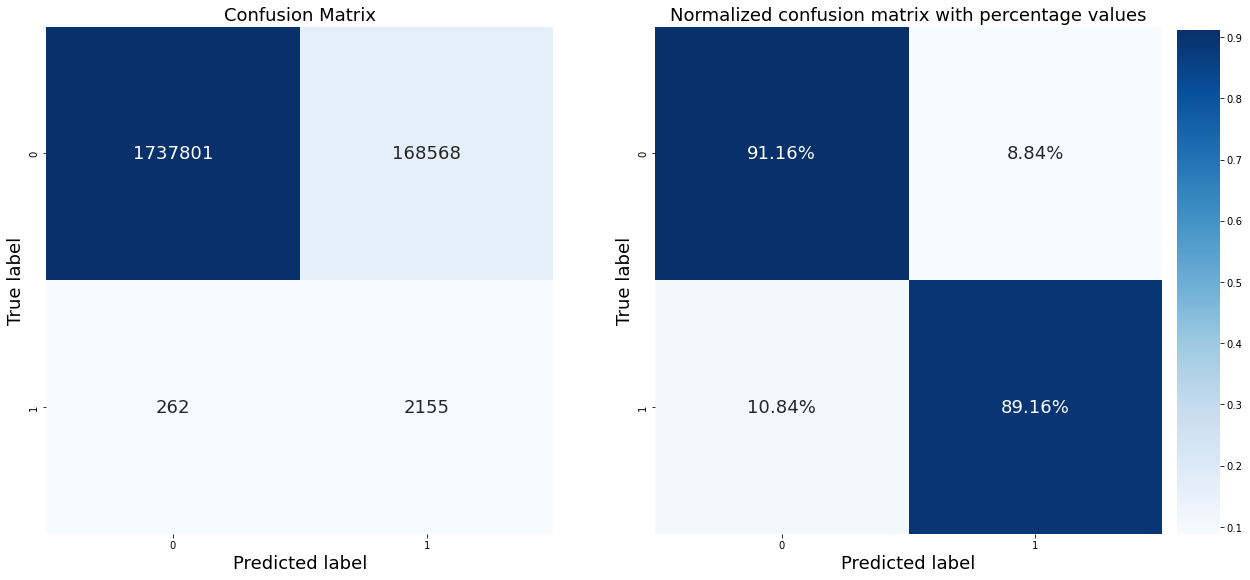

In [24]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=SEED)
lr.fit(x_train, y_train)

print('Logistic regression metrics:')
model_metrics(lr)

In this stage, the Logistic Regression technique was applied with the class_weight='balanced' option, a Cost-Sensitive Learning approach, to handle the class imbalance problem in the dataset. This technique adjusts the class weights inversely proportional to the number of instances in each class, giving more importance to the minority class during the training process.

The model's performance improved significantly with this technique. The resulting metrics were: Accuracy of 91.16%, Precision of 1.26%, Recall of 89.16%, and F1 Score of 2.49%.

The confusion matrix displayed reveals that 91.16% of legitimate transactions (class 0) were correctly identified by the model, while 10.84% were incorrectly classified as fraudulent (class 1). On the other hand, 8.84% of fraudulent transactions (class 1) were incorrectly classified as legitimate, but the model was able to correctly identify 89.16% of fraudulent transactions.

Despite Precision still being low, the high Recall value indicates that the model is effectively identifying the majority of fraudulent transactions, which is a desirable result in this context. The adjustment of class weights managed to mitigate the model's bias towards the majority class, enhancing its ability to detect the minority class.

### Oversampling with SMOTE

SMOTE stands for Synthetic Minority Over-sampling Technique. It's a popular resampling technique used to address the issue of class imbalance in machine learning datasets. The primary purpose of SMOTE is to create 'synthetic' samples in order to increase the number of minority class instances.

To prevent information leakage, the SMOTE technique was only applied to the training data because the purpose of the test data is to simulate a real and unknown environment. By applying SMOTE to the test data, we would be introducing synthetic examples that do not accurately represent the distribution of the real data, compromising the model's ability to generalize correctly to new samples.

In [25]:
#pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=SEED)
x_resampled, y_resampled = smote.fit_resample(x_train,y_train)

In [26]:
df_balanced = pd.concat([y_resampled, x_resampled], axis=1)
df_balanced.groupby('isFraud').count()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
isFraud,,,,,,,,,,,
0,4448038,4448038,4448038,4448038,4448038,4448038,4448038,4448038,4448038,4448038,4448038
1,4448038,4448038,4448038,4448038,4448038,4448038,4448038,4448038,4448038,4448038,4448038


In [27]:
t1 = datetime.now()
lr = LogisticRegression(max_iter=1000, random_state=SEED)
lr.fit(x_resampled, y_resampled)
t2 = datetime.now()
fit_time = (t2-t1).total_seconds()
print('Trained. Elapsed time: {:.2f}'.format(fit_time))

Trained. Elapsed time: 49.76


Logistic regression metrics:
 Accuracy Score  Precision Score  Recall Score  F1 Score
       0.915615         0.013266      0.894497  0.026143



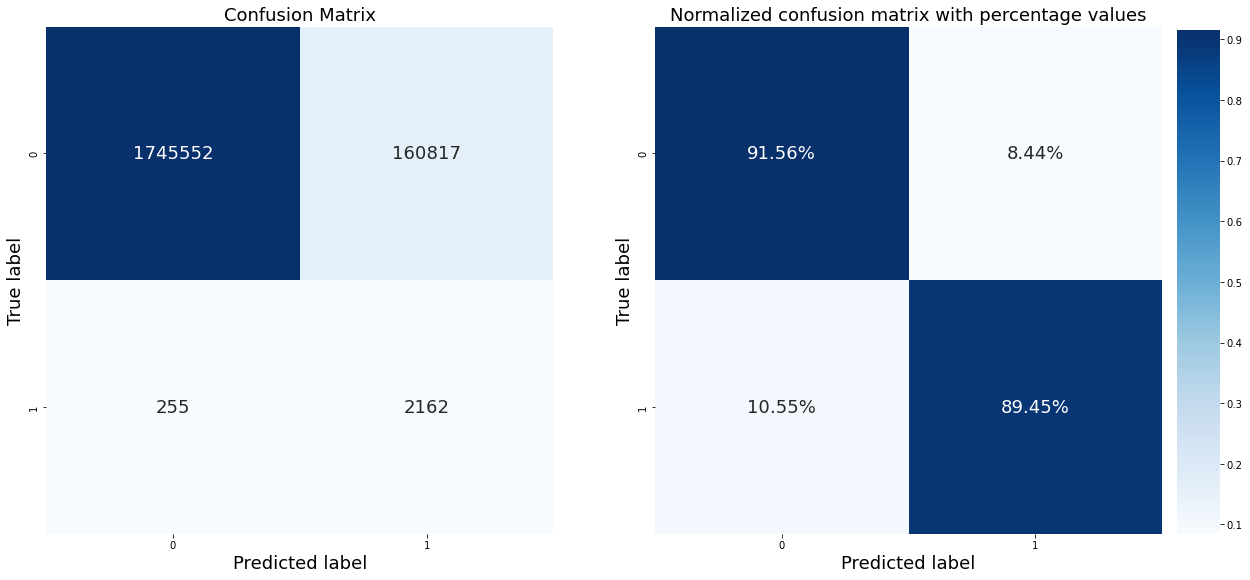

In [28]:
print('Logistic regression metrics:')
model_metrics(lr)

In this stage of the project, an alternative to the previous Cost-Sensitive Learning model was tested, by applying the SMOTE oversampling technique. The metrics of this model showed similar performance to the previous model but with some notable improvements.

The accuracy of the SMOTE model was 0.915615, a slight increase compared to the accuracy of the Cost-Sensitive Learning model, which was 0.911551. Precision also saw a slight increase, from 0.012623 to 0.013266.

The same pattern was observed in the recall metric, which went up from 0.891601 to 0.894497, indicating a larger proportion of true positives being correctly identified. Furthermore, the F1 Score metric, which considers both precision and recall, also had an increase from 0.024893 to 0.026143.

As for the confusion matrix, the new model presented similar rates of correct and incorrect classification for both fraudulent and non-fraudulent transactions. However, there was a slight improvement in the detection rate of fraudulent transactions (11), which increased from 89.16% to 89.45%.

In summary, the application of the SMOTE oversampling technique resulted in a model with slightly better performance than the previous model that used Cost-Sensitive Learning, especially when it comes to detecting fraudulent transactions.

Due to the improved performance achieved with the use of the SMOTE technique to tackle class imbalance, the synthetically generated data will be employed in the subsequent stages of this project.

***

## Evaluation of Classification Models

In this stage of the project, four different classification algorithms are tested. These include the Logistic Regression model, known for its simplicity and efficiency with binary classification problems; the Decision Tree Classifier, appreciated for its ease of interpretation and ability to handle both numerical and categorical data; the Gaussian Naive Bayes, noted for its effectiveness in high-dimensional spaces and the K-Nearest Neighbors (KNN), an instance-based method, robust to noise and effective when the decision boundary is very irregular. By exploring these different algorithms, the aim is to determine the one that offers the best performance for this particular dataset.

In [29]:
models = [
    LogisticRegression(max_iter=1000, random_state=SEED),
    DecisionTreeClassifier(random_state=SEED),
    KNeighborsClassifier(),
    GaussianNB()
]

In [30]:
scores = []
for i, m in enumerate(models):
    
    t1 = datetime.now()
    m.fit(x_resampled, y_resampled)
    t2 = datetime.now()
    fit_time = (t2-t1).total_seconds()
    
    print('{} trained. Elapsed time: {:.2f}'.format(m.__class__.__name__,fit_time))
    
    y_pred = m.predict(x_test)
    
    score = []
    score.append(m.__class__.__name__)
    score.append(metrics.accuracy_score(y_test, y_pred))
    score.append(metrics.precision_score(y_test, y_pred))
    score.append(metrics.recall_score(y_test, y_pred))
    score.append(metrics.f1_score(y_test, y_pred))
    score.append(fit_time)
    score.append(conf_matrix(y_test, y_pred, False))
    
    scores.append(score)

LogisticRegression trained. Elapsed time: 48.66
DecisionTreeClassifier trained. Elapsed time: 96.07
KNeighborsClassifier trained. Elapsed time: 45.49
GaussianNB trained. Elapsed time: 2.36


In [31]:
df_models = pd.DataFrame(scores, columns=['Model_Name', 'Accuracy', 'Precision', 'Recall', 'F1', 'Fit_Time', 'Conf_Matrix'])
df_models

,Model_Name,Accuracy,Precision,Recall,F1,Fit_Time,Conf_Matrix
0,LogisticRegression,0.915615,0.013266,0.894497,0.026143,48.656580,"[[[1745552, 160817], [255, 2162]], [[0.9156422..."
1,DecisionTreeClassifier,0.999402,0.687998,0.965246,0.803375,96.070205,"[[[1905311, 1058], [84, 2333]], [[0.9994450182..."
2,KNeighborsClassifier,0.995202,0.195318,0.894084,0.320599,45.490676,"[[[1897466, 8903], [256, 2161]], [[0.995329865..."
3,GaussianNB,0.965703,0.017140,0.462971,0.033056,2.363035,"[[[1842201, 64168], [1298, 1119]], [[0.9663401..."


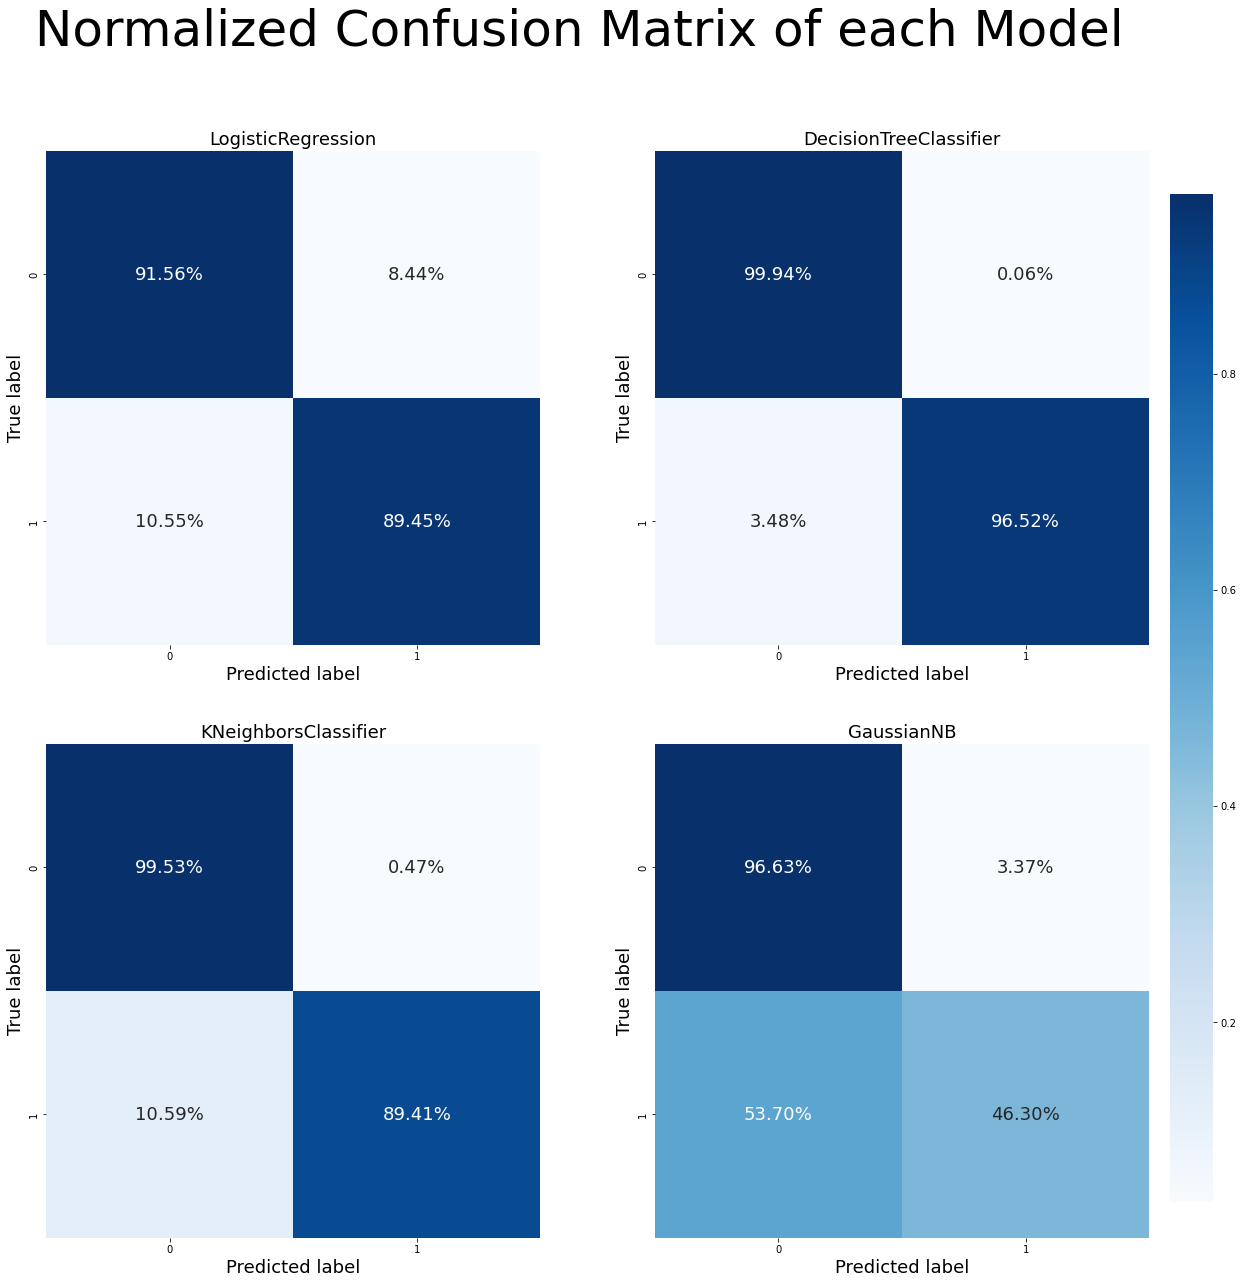

In [70]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(20,20)
fig.suptitle('Normalized Confusion Matrix of each Model', fontsize=50)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
norm = 1

for i, ax in enumerate(ax.flatten()):
    cm = df_models.iloc[i].Conf_Matrix[norm]
    title = df_models.iloc[i].Model_Name
    hm = sns.heatmap(cm, annot=True, annot_kws={"size": 18}, fmt='.2%', ax=ax, cmap="Blues", square=True, cbar_ax=cbar_ax)
    ax.set_xlabel('Predicted label', fontsize=18)
    ax.set_ylabel('True label', fontsize=18)
    ax.set_title(title, fontsize=18)
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])

The <b>Logistic Regression</b> model achieved a solid performance by correctly classifying 91.56% of non-fraudulent transactions and 89.45% of fraudulent transactions. However, it misclassified 10.55% of non-fraudulent transactions as fraudulent and 8.44% of fraudulent transactions as non-fraudulent.

The <b>Decision Tree Classifier</b> displayed an outstanding performance, correctly classifying 99.94% of non-fraudulent transactions and 96.52% of fraudulent transactions. Only a tiny percentage of transactions was misclassified: 0.06% of fraudulent transactions were classified as non-fraudulent and 3.48% of non-fraudulent transactions were classified as fraudulent.

The <b>KNN</b> also displayed a good performance by correctly classifying 99.53% of non-fraudulent transactions. However, it only correctly classified 39.41% of fraudulent transactions. Moreover, it misclassified 0.47% of non-fraudulent transactions as fraudulent and 10.59% of fraudulent transactions as non-fraudulent.

Lastly, the <b>GaussianNB</b> correctly classified 96.63% of non-fraudulent transactions and 46.30% of fraudulent transactions. On the other hand, it misclassified 3.37% of non-fraudulent transactions as fraudulent and 53.70% of fraudulent transactions as non-fraudulent.

These results indicate that, although all four models are capable of correctly classifying most non-fraudulent transactions, performance in classifying fraudulent transactions significantly varies among the models. Specifically, the <b>DecisionTreeClassifier</b> stands out, displaying the highest true positive rate and the lowest false negative rate.

As part of the improvement process, the <b>Random Forest Classifier</b> will be tested as an extension of the Decision Tree Classifier, aiming to leverage its ensemble approach and mitigate the potential overfitting risks associated with a single decision tree model.

***

## Hyperparameter Optimization using Randomized Search and MLflow Tracking

To find the best hyperparameter values for the model, the <b>Randomized Search</b> from Sklearn will be used with <b>cross-validation</b>. This approach involves exploring different combinations of hyperparameters through random iterations. By doing so, the optimal configuration for the model can be determined more efficiently and accurately.

Also, <b>MLflow</b> will be used to monitor the evolution of the model. MLflow is an open platform for managing the machine learning lifecycle, which allows us to track and log model metrics over time, as well as details of different model runs and versions. This will make it easier to compare different hyperparameter configurations and help identify the best setup for our model.

### Defining a Customized RandomizedSearchCV Class

In this step, a custom class called CustomRandomizedSearchCV is being created. This class has been developed to enable cross-validation during the random parameter search. Additionally, it has been designed to store the resulting metrics in MLflow. With this custom class, it will be possible to perform a more accurate and organized analysis of the model metrics throughout the hyperparameter optimization process, thereby facilitating decision-making.

In [33]:
class CustomRandomizedSearchCV(RandomizedSearchCV):
    def __init__(self, estimator, param_distributions, n_iter=10,
                 scoring=None, n_jobs=None, refit=True,
                 cv=None, verbose=0, pre_dispatch='2*n_jobs',
                 random_state=None, error_score=np.nan, return_train_score=False):

        super().__init__(
            estimator=estimator, 
            param_distributions=param_distributions, 
            n_iter=n_iter, 
            scoring=scoring, 
            n_jobs=n_jobs, 
            refit=refit, 
            cv=cv, 
            verbose=verbose, 
            pre_dispatch=pre_dispatch, 
            random_state=random_state, 
            error_score=error_score, 
            return_train_score=return_train_score
        )

    def fit(self, X, y):
        self.best_score_ = 0.0
        self.best_params_ = None
        self.best_estimator_ = None

        candidate_params = list(ParameterSampler(
            self.param_distributions, self.n_iter,
            random_state=self.random_state))

        for i, parameters in enumerate(candidate_params):
            with mlflow.start_run():
                run_name = f"Run {i+1} - {self.estimator.__class__.__name__}"
                mlflow.set_tag("mlflow.runName", run_name)
                
                #Armazena os parâmetros
                self.estimator.set_params(**parameters)
                for key, value in parameters.items():
                    mlflow.log_param(key, value)
                
                #Cross-Validation
                cv_results = cross_validate(self.estimator, X, y, cv=self.cv, scoring=self.scoring, n_jobs=self.n_jobs)
                
                for key, value in cv_results.items():
                    mean_score = np.mean(value)
                    mlflow.log_metric(key, mean_score)
                    
                    # Se for o melhor recall visto até o momento
                    if (key == "test_recall" and mean_score > self.best_score_): 
                        self.best_score_ = mean_score
                        self.best_params_ = parameters
                        
                        #Train and store the best model seen so far based on the 'recall' metric.
                        #self.best_estimator_ = clone(self.estimator)
                        #self.best_estimator_.fit(X, y)
                        #mlflow.sklearn.log_model(self.best_estimator_, "model")
                
                #print('-'*25)
        return self

In [34]:
def optimization(param_grid):
    rf = RandomForestClassifier(random_state = SEED)
    scoring = {'recall': make_scorer(recall_score),'precision': make_scorer(precision_score),"accuracy": make_scorer(accuracy_score)}
    cross_val = KFold(n_splits = 3, shuffle=True, random_state = SEED)

    random_cv = CustomRandomizedSearchCV(rf, param_grid, n_iter=12, cv=cross_val, scoring=scoring, refit="recall", n_jobs=4, random_state = SEED)


    t1 = datetime.now()
    rcv = random_cv.fit(x_resampled, y_resampled)
    t2 = datetime.now()

    fit_time = (t2-t1).total_seconds()
    print('Trained. Elapsed time: {:.2f}'.format(fit_time))

### First Parameter Search: Setting a new Experiment

In [35]:
mlflow.set_tracking_uri("http://localhost:5000")
experiment = mlflow.set_experiment('First_Search')

In this code block, we are setting up the MLflow tracking environment to record the results of the experiment. We set the tracking URI to "http://localhost:5000" and create a new experiment called "First_Search". This configuration enables us to store and compare the results of the first parameter search in an organized manner.

### Parameter Grid Definition and Search Execution

In [36]:
n_estimators = np.arange(20, 250, step=20)
criterion = ["gini", "entropy"]
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(2, 10, step=1))
bootstrap = [True, False]

param_grid = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "bootstrap": bootstrap,
}

optimization(param_grid)

Trained. Elapsed time: 19597.98


In [37]:
experiment_id = str(experiment.experiment_id)
runs = mlflow.search_runs(experiment_ids=experiment_id)
runs_df = runs[['run_id',
                'metrics.test_recall', 
                'metrics.test_accuracy', 
                'metrics.test_precision', 
                'metrics.fit_time', 
                'metrics.score_time']]
runs_sorted = runs_df.sort_values('metrics.test_recall', ascending=False)
runs_sorted

,run_id,metrics.test_recall,metrics.test_accuracy,metrics.test_precision,metrics.fit_time,metrics.score_time
4,2f057b44dc63480f94c01a1a7dddc899,0.996391,0.985035,0.974264,1637.667474,32.065486
8,0e6268695d2b4ae9be1a0779690c13e8,0.996106,0.989504,0.983125,2566.531072,36.883022
0,827f12c8af4442d19827d6d6e3930526,0.996055,0.986374,0.977141,1790.983325,35.303904
9,cc3cf30ba5b5478db10015ad4dc5e72a,0.995270,0.983600,0.972576,328.089878,6.967029
3,90c58ea185fb47fcaef8e49dd9bc2a7e,0.987653,0.979277,0.971381,1258.680092,26.614640
11,7644d673e88b4305b58babd4163a331f,0.984622,0.972142,0.960645,1884.709393,30.131444
2,634c0b23b664483ea93d9cdb15be1d3f,0.982524,0.964878,0.949032,1020.477285,23.775698
1,fb6f3713ba3148e88f43cbe181d7809f,0.976795,0.972013,0.967542,2150.789616,35.056142
5,1b718ea169a3478098093c529f1c14f7,0.972780,0.957219,0.943419,1444.378213,35.791973
10,5dab165d0779457283ea07e203d131ae,0.971922,0.957630,0.944912,1859.668607,46.134719


The optimization process was performed using a Random Forest Classifier with various combinations of hyperparameters. The parameter grid consisted of different values for "n_estimators", "criterion", "max_features", "max_depth", and "bootstrap". The best-performing models were evaluated based on the test recall metric.

The results table shows the run_id, test recall, test accuracy, test precision, fit time (in seconds), and score time (in seconds) for each model. The models are sorted in descending order based on the test recall.

The top-performing model (run_id: 2f057b44dc63480f94c01a1a7dddc899) achieved a test recall of 0.996391, indicating that it successfully identified 99.64% of fraudulent transactions. It also demonstrated high test accuracy (0.985035) and test precision (0.974264). The fit time for this model was 1637.67 seconds, and the score time was 32.07 seconds.

The other models in the table also achieved respectable test recall scores, ranging from 0.996106 to 0.969436. They exhibited varying levels of test accuracy, test precision, fit time, and score time.

These results provide insights into the performance of the Random Forest Classifier with different hyperparameter settings. Further analysis and comparison can be performed to select the best model for the bank fraud detection task.

### Evaluation of Models

In this stage, the models generated by the previous hyperparameter search will be tested and evaluated. The selected models will use the optimized hyperparameters found in the previous stage. Performance metrics such as recall, precision, and accuracy will be calculated to assess the fraud detection capability of each model. This evaluation will enable an objective comparison of the models' performance and aid in selecting the most suitable model for bank fraud detection in the dataset.

In [38]:
def plot_roc (y_test, y_probs, x_lim1, x_lim2):
    
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(20,10)

    ax[0].plot(fpr, tpr, label='ROC curve')
    ax[0].plot([0, 1], [0, 1], 'k--') 
    ax[0].set_xlim([0.0, x_lim1]) #1.0
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic')
    ax[0].legend(loc="lower right")

    ax[1].plot(fpr, tpr, label='ROC curve')
    ax[1].plot([0, 1], [0, 1], 'k--') 
    ax[1].set_xlim([0.0, x_lim2]) #0.05
    ax[1].set_ylim([0.0, 1.05]) 
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic')
    ax[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

<div style="text-align:center">
    <img src="Roc_curve.png" alt="ROC" width="25%">
</div>

The Receiver Operating Characteristic (ROC) curve is a graphical representation that illustrates the performance of a binary classification model at different levels of sensitivity and specificity. It shows the relationship between the true positive rate (TPR) and the false positive rate (FPR) at various decision threshold settings. The closer the ROC curve is to the upper left corner of the graph, the better the model's performance, indicating a high ability to correctly distinguish between the positive and negative classes. The area under the ROC curve (AUC-ROC) is a common metric used to summarize the overall quality of the model, where a value close to 1 indicates a highly accurate and effective model. The ROC curve is a valuable tool for evaluating and comparing classification models in different scenarios and can assist in selecting the most suitable model for a specific classification task.

In [76]:
def convert_params(params):
    int_keys = ['max_depth', 'n_estimators']
    bool_keys = ['bootstrap']

    for key in int_keys:
        if key in params:
            params[key] = int(params[key])

    for key in bool_keys:
        if key in params:
            if params[key].lower() == 'true':
                params[key] = True
            elif params[key].lower() == 'false':
                params[key] = False
    return params

In [77]:
#passar X_TRAIN = RESAMPLED depois
#testa os modelos passados por parâmetro com os dados de teste.
def model_analysis (ids, x_train, y_train, x_test):
    models = []
    
    for i in range(len(ids)):
        #consulta os parâmetros do modelo pelo ID
        run_info = mlflow.get_run(ids[i])
        parameters = convert_params(run_info.data.params)
        mlflow.end_run()
        
        rf = RandomForestClassifier(**parameters)
        
        t1 = datetime.now()
        rf.fit(x_train,y_train)
        t2 = datetime.now()
        
        fit_time = (t2-t1).total_seconds()
        print('Model {} ({}) Trained. Elapsed time: {:.2f}'.format(i+1,ids[i],fit_time))   
        
        y_probs = rf.predict_proba(x_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
        y_pred = rf.predict(x_test)
        lstMetrics = []
        lstMetrics.append(metrics.accuracy_score(y_test, y_pred))
        lstMetrics.append(metrics.precision_score(y_test, y_pred))
        lstMetrics.append(metrics.recall_score(y_test, y_pred))
        lstMetrics.append(metrics.f1_score(y_test, y_pred))
        lstMetrics.append(fit_time)
        
        with mlflow.start_run(run_id=ids[i]):
            model_path = "{}/model".format(ids[i])
            mlflow.sklearn.log_model(rf, model_path)
            mlflow.log_metric('fit_time_model', fit_time)
            mlflow.log_metric('recall_score_model', lstMetrics[2])
            mlflow.log_metric('precision_score_model', lstMetrics[1])
            mlflow.log_metric('accuracy_score_model', lstMetrics[0])
            mlflow.log_metric('f1_score_model', lstMetrics[3])
        
        #armazena as informações do modelo na lista
        model = {'run_id': ids[i],
                 'fit_time': lstMetrics[4],
                'recall_score': lstMetrics[2],
                'precision_score': lstMetrics[1],
                'accuracy_score': lstMetrics[0],
                'f1_score': lstMetrics[3],
                'roc_curve': [fpr, tpr, thresholds],
                'y_pred': y_pred,
                'y_probs': y_probs}
        models.append(model)
    return models

In the model_analysis function, an analysis of the models passed as parameters is performed using the test data. Firstly, the parameters of each model are retrieved based on their respective IDs. Next, the model is trained using the training data, and the training time is recorded. The trained model is stored in MLflow.

Subsequently, predictions are made using the model, and various performance metrics, including accuracy, precision, recall, and F1 score, are calculated. Additionally, the ROC curve is computed to assess the model's performance at different probability thresholds. The predictions and probabilities are stored along with the model information.

Finally, the function returns a list of models with their respective information, enabling a detailed analysis of each model's performance.

In [43]:
#testando os 5 melhores modelos
ids = runs_sorted.iloc[:5]['run_id'].values

mlist = model_analysis(ids, x_resampled, y_resampled, x_test)

Model 1 (2f057b44dc63480f94c01a1a7dddc899) Trained. Elapsed time: 2502.26
Model 2 (0e6268695d2b4ae9be1a0779690c13e8) Trained. Elapsed time: 3809.33
Model 3 (827f12c8af4442d19827d6d6e3930526) Trained. Elapsed time: 2573.31
Model 4 (cc3cf30ba5b5478db10015ad4dc5e72a) Trained. Elapsed time: 494.52
Model 5 (90c58ea185fb47fcaef8e49dd9bc2a7e) Trained. Elapsed time: 1788.83


In [78]:
df_mlist = pd.DataFrame(mlist)
df_mlist.rename(index=lambda x: x + 1, inplace=True)
df_mlist.iloc[:,:6]

,run_id,fit_time,recall_score,precision_score,accuracy_score,f1_score
1,2f057b44dc63480f94c01a1a7dddc899,2502.264180,0.993380,0.042636,0.971747,0.081763
2,0e6268695d2b4ae9be1a0779690c13e8,3809.325252,0.990484,0.066678,0.982432,0.124945
3,827f12c8af4442d19827d6d6e3930526,2573.310689,0.989243,0.047807,0.975037,0.091206
4,cc3cf30ba5b5478db10015ad4dc5e72a,494.524637,0.993794,0.045002,0.973288,0.086106
5,90c58ea185fb47fcaef8e49dd9bc2a7e,1788.828260,0.978899,0.040550,0.970645,0.077875


In [ ]:
# in progress.. :)